In [1]:
import sys
sys.path.append("...")
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import ACTIVITIES, ABBR, TZ_PARIS, TZ_LONDON
from src.viz_style import apply_nature_style

apply_nature_style()

In [3]:
from src.utils_time import to_local_time_series, split_cross_midnight, week_start_monday
from src.utils_split import split_users_by_hash
from src.regularity import regularity_report, summarize_reg, compute_user_hex_stats, infer_home_work_anchors, make_hex_lookup

In [4]:
from pathlib import Path

ROOT = Path("...")
OUT_DATA = ROOT / "outputs" / "data"
OUT_FIG = ROOT / "outputs" / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

paris_valid = pd.read_parquet(OUT_DATA / "paris_stays_valid.parquet")
paris_valid["user_id"] = paris_valid["user_id"].astype(str)
paris_valid["start_time"] = pd.to_datetime(paris_valid["start_time"])
paris_valid["end_time"] = pd.to_datetime(paris_valid["end_time"])
paris_valid["duration_min"] = pd.to_numeric(paris_valid["duration_min"], errors="coerce")
paris_valid["hex_id"] = paris_valid["hex_id"].astype(str).replace({"": np.nan, "nan": np.nan})
paris_valid = paris_valid.dropna(subset=["hex_id","start_time","end_time","duration_min","y_true"]).copy()

# Huff POI parquet produced in notebook 03
paris_poi_huff_path = OUT_DATA / "paris_poi_huff_k4_b1.5.parquet"
paris_poi_huff = pd.read_parquet(paris_poi_huff_path)
paris_poi_huff["hex_id"] = paris_poi_huff["hex_id"].astype(str)

POI_COLS = ["poi_edu_cnt","poi_health_cnt","poi_retail_cnt","poi_leisure_cnt",
            "poi_transport_cnt","poi_accom_cnt","poi_office_cnt","poi_total_cnt"]

# Ensure all needed columns exist
for c in POI_COLS:
    if c not in paris_poi_huff.columns:
        paris_poi_huff[c] = 0

poi_lookup_paris = {r.hex_id: r for r in paris_poi_huff[["hex_id"]+POI_COLS].itertuples(index=False)}

print("Paris valid stays:", len(paris_valid), "users:", paris_valid["user_id"].nunique())
print("Paris Huff POI hex rows:", len(paris_poi_huff))

Paris valid stays: 12437 users: 621
Paris Huff POI hex rows: 29628


In [5]:
import math
import h3
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

labels = ["HOME","WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"]

# ---------- temporal signature (UK S3, mapped to your labels) ----------
HOURS = list(range(6,24))
UK = {
 "Education":      [0.1,0.7,0.9,0.5,0.3,0.3,0.3,0.3,0.3,0.5,0.3,0.3,0.3,0.3,0.3,0.1,0.1,0.1],
 "EatingDrinking": [0.1,0.7,0.7,0.5,0.5,0.9,0.9,0.7,0.5,0.3,0.5,0.7,0.9,0.9,0.5,0.5,0.3,0.3],
 "Shopping1":      [0.1,0.5,0.5,0.5,0.5,0.5,0.7,0.7,0.5,0.5,0.5,0.5,0.3,0.7,0.7,0.5,0.5,0.5],
 "Shopping2":      [0.1,0.1,0.1,0.5,0.7,0.7,0.3,0.5,0.7,0.7,0.7,0.7,0.1,0.1,0.1,0.1,0.1,0.1],
 "Entertainment":  [0.1,0.1,0.1,0.3,0.5,0.5,0.7,0.5,0.5,0.5,0.5,0.5,0.3,0.7,0.9,0.7,0.5,0.3],
 "Others":         [0.3,0.3,0.7,0.5,0.7,0.7,0.3,0.3,0.5,0.5,0.5,0.5,0.3,0.3,0.5,0.5,0.5,0.5],
}

def norm(p):
    p = np.maximum(np.array(p, dtype=float), 0)
    return p/p.sum()

TEMP = {}
TEMP["STUDY"] = norm(UK["Education"])
TEMP["PURCHASE"] = norm(np.maximum(UK["Shopping1"], UK["Shopping2"]))
TEMP["LEISURE"] = norm(np.maximum(UK["EatingDrinking"], UK["Entertainment"]))
TEMP["OTHER"] = norm(UK["Others"])
TEMP["HEALTH"] = norm(UK["Others"])  # approximation

def temporal_prob(label: str, ts: pd.Timestamp) -> float:
    hour = ts.hour
    if hour < 6 or hour >= 24:
        return 1e-6
    return float(TEMP[label][hour-6])

# ---------- H3 helpers ----------
def h3_disk(cell, k):
    return h3.grid_disk(cell, k) if hasattr(h3, "grid_disk") else h3.k_ring(cell, k)

def h3_dist(a, b):
    return h3.grid_distance(a, b) if hasattr(h3, "grid_distance") else h3.h3_distance(a, b)

# ---------- anchors (reuse your stable methods in src.regularity) ----------
# We build anchors from stays_valid itself (same as you did before)
hs = compute_user_hex_stats(paris_valid)
anchors = infer_home_work_anchors(hs)
home_lookup = dict(zip(anchors["user_id"], anchors["home_hex"]))
work_lookup = dict(zip(anchors["user_id"], anchors["work_hex"]))

def is_in_anchor(hex_id: str, anchor_hex: str, mode="kring", k=1):
    if anchor_hex is None:
        return False
    if mode == "exact":
        return str(hex_id) == str(anchor_hex)
    if mode == "kring":
        return str(hex_id) in set(h3_disk(str(anchor_hex), k))
    raise ValueError(mode)

# ---------- POI access ----------
def get_poi_row(h):
    return poi_lookup_paris.get(str(h), None)

def poi_cnt(row, label):
    if row is None:
        return 0.0
    if label == "STUDY":
        return float(getattr(row, "poi_edu_cnt", 0) or 0)
    if label == "HEALTH":
        return float(getattr(row, "poi_health_cnt", 0) or 0)
    if label == "PURCHASE":
        return float(getattr(row, "poi_retail_cnt", 0) or 0)
    if label == "LEISURE":
        return float(getattr(row, "poi_leisure_cnt", 0) or 0)
    if label == "OTHER":
        # residual / other-like
        total = float(getattr(row, "poi_total_cnt", 0) or 0)
        sem = float((getattr(row,"poi_edu_cnt",0) or 0) + (getattr(row,"poi_health_cnt",0) or 0) +
                    (getattr(row,"poi_retail_cnt",0) or 0) + (getattr(row,"poi_leisure_cnt",0) or 0))
        return max(0.0, total - sem)
    return 0.0

# ---------- spatial Huff-like score around hex (ring distance decay) ----------
def spatial_score(h, label, k_ring=4, beta=1.5):
    if not isinstance(h, str) or len(h) < 5:
        return 0.0
    s = 0.0
    # disk includes center
    for nb in h3_disk(h, k_ring):
        row = get_poi_row(str(nb))
        cnt = poi_cnt(row, label)
        if cnt <= 0:
            continue
        d = h3_dist(h, str(nb))
        s += cnt / ((float(d)+1.0)**beta)
    return float(s)

# ---------- baseline1 decoding ----------
def baseline1_predict(stays, anchor_mode="kring", anchor_k=1, k_ring=4, beta=1.5, eps=1e-8):
    candidates = ["STUDY","HEALTH","PURCHASE","LEISURE","OTHER"]
    out = stays.sort_values(["user_id","start_time"]).copy()
    preds = []

    for r in out.itertuples(index=False):
        u = str(r.user_id); h = str(r.hex_id); st = r.start_time

        if is_in_anchor(h, home_lookup.get(u), mode=anchor_mode, k=anchor_k):
            preds.append("HOME"); continue
        if is_in_anchor(h, work_lookup.get(u), mode=anchor_mode, k=anchor_k):
            preds.append("WORK"); continue

        best_lab = "OTHER"
        best_score = -1e18
        any_spatial = False

        for lab in candidates:
            sp = spatial_score(h, lab, k_ring=k_ring, beta=beta)
            if sp > 0:
                any_spatial = True
            tm = temporal_prob(lab, st)
            score = math.log(eps + sp) + math.log(eps + tm)
            if score > best_score:
                best_score = score
                best_lab = lab

        if not any_spatial:
            best_lab = "OTHER"
        preds.append(best_lab)

    out["y_pred_rule"] = preds
    return out

In [14]:
import matplotlib.pyplot as plt

HOURS = list(range(6,24))

def learn_s3_from_stays(stays_df, label_col="y_true", alpha=1.0, by_weektype=False):
    """
    Learn temporal signature p(hour | label) from stays.
    Returns:
      - if by_weektype=False: dict[label] -> vec(18)
      - if by_weektype=True : dict[(weekend,label)] -> vec(18)
    """
    d = stays_df.copy()
    d["start_time"] = pd.to_datetime(d["start_time"], errors="coerce")
    d["hour"] = d["start_time"].dt.hour
    d = d[d["hour"].between(6,23)].copy()

    labels_temp = ["HOME", "WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"]  # baseline non-home/work

    if not by_weektype:
        out = {}
        for lab in labels_temp:
            sub = d[d[label_col] == lab]
            cnt = sub["hour"].value_counts().reindex(HOURS, fill_value=0).values.astype(float)
            cnt = cnt + alpha
            out[lab] = cnt / cnt.sum()
        return out

    # weekday/weekend split
    d["weekend"] = (d["start_time"].dt.weekday >= 5).astype(int)
    out = {}
    for w in [0,1]:
        for lab in labels_temp:
            sub = d[(d["weekend"]==w) & (d[label_col]==lab)]
            cnt = sub["hour"].value_counts().reindex(HOURS, fill_value=0).values.astype(float)
            cnt = cnt + alpha
            out[(w,lab)] = cnt / cnt.sum()
    return out

# ---- (A) Recommended: learn from Paris train, evaluate on Paris valid ----
paris_train = pd.read_parquet(OUT_DATA / "paris_stays_train.parquet")
paris_train["start_time"] = pd.to_datetime(paris_train["start_time"])
paris_train["y_true"] = paris_train["y_true"].astype(str)

S3_PARIS_train = learn_s3_from_stays(paris_train, alpha=1.0, by_weektype=False)

# ---- (B) Your requested variant: learn from Paris valid (not recommended for evaluation) ----
S3_PARIS_valid = learn_s3_from_stays(paris_valid, alpha=1.0, by_weektype=False)

# UK S3 signature already defined in Cell 2 as TEMP (STUDY/PURCHASE/LEISURE/HEALTH/OTHER)
UK_SIG = {k: np.array(v, dtype=float) for k,v in TEMP.items()}  # TEMP from Cell 2

def js_divergence(p, q):
    p = np.clip(p, 1e-12, 1.0); p = p/p.sum()
    q = np.clip(q, 1e-12, 1.0); q = q/q.sum()
    m = 0.5*(p+q)
    return 0.5*(np.sum(p*np.log(p/m)) + np.sum(q*np.log(q/m)))

def compare_s3(uk_sig, fr_sig, name="Paris(train)"):
    rows=[]
    for lab in ["HOME", "WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"]:
        uk = uk_sig[lab]
        fr = fr_sig[lab]
        rows.append({
            "label": lab,
            "UK_peak": HOURS[int(np.argmax(uk))],
            "FR_peak": HOURS[int(np.argmax(fr))],
            "UK_mean_hour": float(np.sum(np.array(HOURS)*uk)),
            "FR_mean_hour": float(np.sum(np.array(HOURS)*fr)),
            "JSD(UK,FR)": float(js_divergence(uk, fr)),
        })
    cmp = pd.DataFrame(rows).sort_values("JSD(UK,FR)", ascending=False)
    print(f"\n=== UK vs {name} S3 comparison ===")
    display(cmp)

compare_s3(UK_SIG, S3_PARIS_train, name="Paris(train)")
compare_s3(UK_SIG, S3_PARIS_valid, name="Paris(valid)")

# Plot curves (UK vs Paris(train)) — 2×3 small multiples
apply_nature_style()
labels_plot = ["HOME", "WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"]
fig, axes = plt.subplots(2,3, figsize=(12,6), sharex=True)
axes = axes.flatten()
x = np.array(HOURS)

for i, lab in enumerate(labels_plot):
    ax = axes[i]
    ax.plot(x, UK_SIG[lab], label="UK S3")
    ax.plot(x, S3_PARIS_train[lab], label="Paris S3 (train)")
    ax.set_title(lab)
    ax.set_xlim(6,23)
    ax.set_xticks(np.arange(6,24,2))
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].legend(loc="upper right")
axes[5].axis("off")
fig.suptitle("Temporal signatures: UK S3 vs Paris-learned S3 (train)", y=1.02)
plt.tight_layout()
plt.show()
plt.close(fig)

KeyError: 'HOME'

In [17]:
S3_PARIS_train

{'HOME': array([0.00282451, 0.00902616, 0.02855213, 0.02628024, 0.03242048,
        0.05206926, 0.06913914, 0.04758688, 0.0405256 , 0.04562201,
        0.07497237, 0.11770846, 0.15577797, 0.12452413, 0.07012158,
        0.04101682, 0.03708707, 0.02474518]),
 'WORK': array([0.02059292, 0.09052925, 0.25577   , 0.20234779, 0.0569041 ,
        0.03840032, 0.06267409, 0.11062475, 0.05760048, 0.03074015,
        0.02487067, 0.01939912, 0.01233585, 0.00885396, 0.00338241,
        0.00268603, 0.00109431, 0.00119379]),
 'STUDY': array([0.00088183, 0.09435626, 0.28483245, 0.1622575 , 0.08994709,
        0.0361552 , 0.06525573, 0.1031746 , 0.0643739 , 0.02557319,
        0.02998236, 0.01763668, 0.01234568, 0.00440917, 0.00352734,
        0.0026455 , 0.00176367, 0.00088183]),
 'PURCHASE': array([0.00053015, 0.00424122, 0.02531478, 0.04864148, 0.07925779,
        0.1064281 , 0.12856196, 0.07753479, 0.06719682, 0.0785951 ,
        0.08654738, 0.10430749, 0.11172962, 0.05712392, 0.0156395 ,
        0

In [7]:
# Choose which Paris S3 you want to use for evaluation
# Recommended:
S3_FR = S3_PARIS_train
# If you really want the (leaky) variant:
# S3_FR = S3_PARIS_valid

def temporal_prob_from_s3(label: str, ts: pd.Timestamp, s3_dict: dict) -> float:
    hour = ts.hour
    if hour < 6 or hour >= 24:
        return 1e-6
    return float(s3_dict[label][hour-6])

def baseline1_predict_with_temporal(stays, temporal_source="UK"):
    """
    temporal_source: "UK" or "PARIS"
    """
    def tm(lab, st):
        if temporal_source == "UK":
            return temporal_prob(lab, st)  # uses UK TEMP from Cell 2
        return temporal_prob_from_s3(lab, st, S3_FR)

    candidates = ["STUDY","HEALTH","PURCHASE","LEISURE","OTHER"]
    out = stays.sort_values(["user_id","start_time"]).copy()
    preds = []
    for r in out.itertuples(index=False):
        u = str(r.user_id); h = str(r.hex_id); st = r.start_time

        if is_in_anchor(h, home_lookup.get(u), mode="kring", k=1):
            preds.append("HOME"); continue
        if is_in_anchor(h, work_lookup.get(u), mode="kring", k=1):
            preds.append("WORK"); continue

        best_lab = "OTHER"
        best_score = -1e18
        any_spatial = False
        eps = 1e-8

        for lab in candidates:
            sp = spatial_score(h, lab, k_ring=4, beta=1.5)
            if sp > 0:
                any_spatial = True
            score = math.log(eps + sp) + math.log(eps + tm(lab, st))
            if score > best_score:
                best_score = score
                best_lab = lab

        if not any_spatial:
            best_lab = "OTHER"
        preds.append(best_lab)

    out["y_pred_rule"] = preds
    return out

def eval_baseline(pred_df, name):
    y_true = pred_df["y_true"].values
    y_pred = pred_df["y_pred_rule"].values
    acc = accuracy_score(y_true, y_pred)
    macro = f1_score(y_true, y_pred, average="macro", labels=labels)
    macro_weak = f1_score(y_true, y_pred, average="macro", labels=["WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"])
    print(f"\n=== {name} ===")
    print("ACC:", acc, "Macro:", macro, "Macro excl HOME:", macro_weak)
    return acc, macro, macro_weak

pred_ukS3 = baseline1_predict_with_temporal(paris_valid, temporal_source="UK")
pred_frS3 = baseline1_predict_with_temporal(paris_valid, temporal_source="PARIS")

eval_baseline(pred_ukS3, "Baseline1 + UK S3 (Huff POI)")
eval_baseline(pred_frS3, "Baseline1 + Paris-learned S3 (Huff POI)")


=== Baseline1 + UK S3 (Huff POI) ===
ACC: 0.4305700731687706 Macro: 0.2961232903537206 Macro excl HOME: 0.2346468809626132

=== Baseline1 + Paris-learned S3 (Huff POI) ===
ACC: 0.4418268071078234 Macro: 0.3100359106274995 Macro excl HOME: 0.2508782712820219


(0.4418268071078234, 0.3100359106274995, 0.2508782712820219)

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

OUT_FIG = Path("/Users/pang/Codes/GISRUK/outputs/figures")
OUT_DATA = Path("/Users/pang/Codes/GISRUK/outputs/data")
OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_DATA.mkdir(parents=True, exist_ok=True)

# Use Paris-learned S3 baseline as the "final baseline" for Paris
pred_final = pred_frS3.copy()

y_true = pred_final["y_true"].values
y_pred = pred_final["y_pred_rule"].values

acc = accuracy_score(y_true, y_pred)
macro = f1_score(y_true, y_pred, average="macro", labels=labels)
macro_weak = f1_score(y_true, y_pred, average="macro", labels=["WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"])

print("Final Baseline1 (Paris S3 + Huff POI) ACC:", acc)
print("Final Baseline1 Macro-F1:", macro)
print("Final Baseline1 Macro-F1 excl HOME:", macro_weak)
print(classification_report(y_true, y_pred, labels=labels, digits=3, zero_division=0))

# Save row-normalized CM as CSV for later side-by-side comparisons
cm = confusion_matrix(y_true, y_pred, labels=labels)
cmn = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

cm_csv = OUT_DATA / "cm_baseline1_parisS3_huff_row_norm.csv"
np.savetxt(cm_csv, cmn, delimiter=",", fmt="%.6f")
print("Saved:", cm_csv)

Final Baseline1 (Paris S3 + Huff POI) ACC: 0.4418268071078234
Final Baseline1 Macro-F1: 0.3100359106274995
Final Baseline1 Macro-F1 excl HOME: 0.2508782712820219
              precision    recall  f1-score   support

        HOME      0.798     0.570     0.665      4153
        WORK      0.646     0.466     0.542      2566
       STUDY      0.045     0.042     0.044       237
    PURCHASE      0.346     0.466     0.397      1832
     LEISURE      0.199     0.498     0.285      1290
      HEALTH      0.182     0.007     0.013       301
       OTHER      0.250     0.206     0.225      2058

    accuracy                          0.442     12437
   macro avg      0.352     0.322     0.310     12437
weighted avg      0.518     0.442     0.460     12437

Saved: /Users/pang/Codes/GISRUK/outputs/data/cm_baseline1_parisS3_huff_row_norm.csv


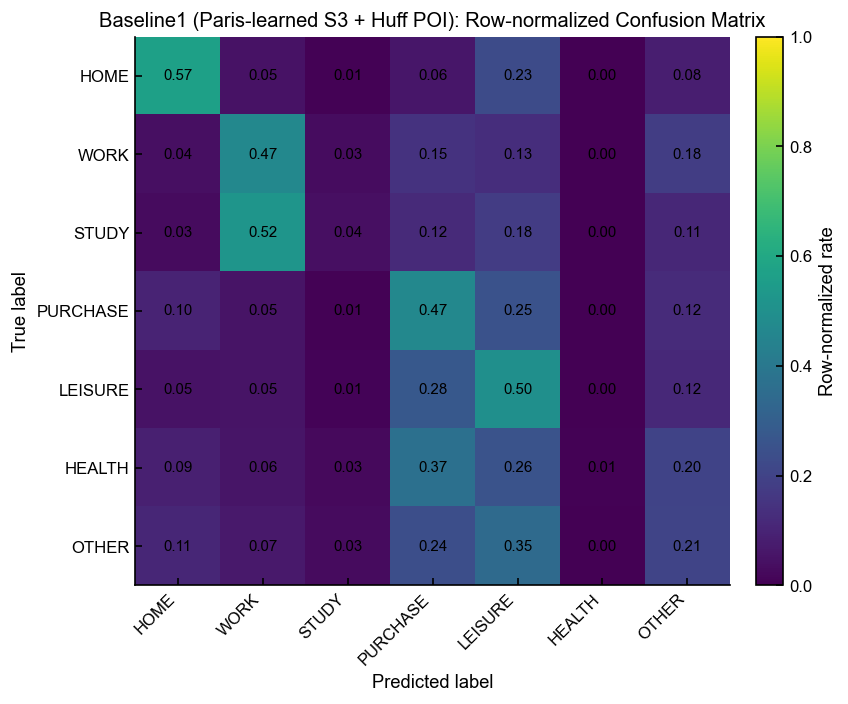

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_baseline1_parisS3_huff_row_norm_cm.png


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

apply_nature_style()  # from src.viz_style

def plot_row_norm_cm_local(y_true, y_pred, labels, outpath, title, annotate=True):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cmn = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    im = ax.imshow(cmn, vmin=0.0, vmax=1.0, aspect="auto")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(direction="in")
    cbar.set_label("Row-normalized rate", rotation=90)

    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if annotate:
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax.text(j, i, f"{cmn[i,j]:.2f}", ha="center", va="center", fontsize=9)

    plt.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    return cm, cmn

cm_png = OUT_FIG / "paris_baseline1_parisS3_huff_row_norm_cm.png"
cm, cmn = plot_row_norm_cm_local(
    y_true, y_pred, labels,
    outpath=str(cm_png),
    title="Baseline1 (Paris-learned S3 + Huff POI): Row-normalized Confusion Matrix",
    annotate=True
)
print("Saved:", cm_png)